# 0.0 IMPORTS

In [1]:
import re
import warnings
import sweetviz
import IPython
import pickle
import itertools

import pandas            as pd
import numpy             as np
import lightgbm          as lgb
import xgboost           as xgb
import seaborn           as sns

from category_encoders       import TargetEncoder
from sklearn.preprocessing   import OneHotEncoder
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import GaussianNB
from scipy                   import stats
from unidecode               import unidecode
from catboost                import CatBoostClassifier
from skopt                   import gp_minimize
from sklearn.model_selection import cross_val_score, KFold
from imblearn                import over_sampling
from sklearn                 import svm
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from sklearn.tree            import DecisionTreeClassifier
from sklearn.neural_network  import MLPClassifier

from sklearn                 import model_selection   as ms
from sklearn                 import metrics           as m
from matplotlib              import pyplot            as plt
from imblearn                import combine           as c

C:\Users\mathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 AUX FUNCTIONS

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

def ml_error( model_name, ytest, yhat ):
    f1 = m.f1_score( ytest, yhat )

    return pd.DataFrame( {'Model name': model_name,
                          'F1': f1 }, index=[0] )

## 0.2 READ DATASETS

In [3]:
df = pd.read_csv('datasets/train.csv')

# 1.0 DATA DESCRIPTION

# 2.0 DATA FILTERING

In [4]:
df2 = df.copy()

df2['idade'] = df2['idade'].apply( lambda x: int(str(x)[:2]) if x>100 else x )

df2['taxa_juros'] = df2['taxa_juros'].apply( lambda x: int(str(x)[:2]) if x>100 else x )

mediana_cartao = df2['num_cartoes_credito'].median()
df2['num_cartoes_credito'] = df2['num_cartoes_credito'].apply( lambda x: mediana_cartao if x>100 else x )

# 3.0 FEATURE ENGINEERING

In [5]:
df3 = df2.copy()

df3['porcentagem_investido'] = df3.apply( lambda x: x.valor_em_investimentos / x.renda_anual, axis=1 )

df3['renda_anual'] = df3['renda_anual'].apply( lambda x: x/12 )

df3['faixa_num_emprestimos'] = df3['num_emprestimos'].apply( lambda x: '0' if x <= 0 else 
                                                                       '1 - 3' if x >= 1 and x <= 3 else
                                                                       '4 - 6' if x >= 4 and x <= 6 else
                                                                       '6 - 9' if x >= 6 and x <= 9 else
                                                                       '10 +' if x > 10 else x)

In [6]:
df3['porcentagem_divida'] = df3.apply( lambda x: x['renda_anual'] / x['divida_atual'], axis=1 )

# 4.0 EDA

In [7]:
df4 = df3.copy()

# 5.0 DATA PREPARATION

In [8]:
df5 = df3.copy()

## 5.1 Rescaling

In [9]:
# Min Max Scaler
mms = MinMaxScaler()

df5['idade'] = mms.fit_transform( df5[['idade']].values )
pickle.dump( mms, open( 'encoders/idade_scaler', 'wb') )

df5['porcentagem_investido'] = mms.fit_transform( df5[['porcentagem_investido']].values )
# pickle.dump( mms, open( 'encoders/idade_scaler', 'wb') )

# Robust Scaler
rs = RobustScaler()

df5['saldo_atual'] = rs.fit_transform( df5[['saldo_atual']].values )
pickle.dump( rs, open( 'encoders/saldo_atual_scaler', 'wb') )

df5['divida_atual'] = rs.fit_transform( df5[['divida_atual']].values )
pickle.dump( rs, open( 'encoders/divida_atual_scaler', 'wb') )

df5['renda_anual'] = rs.fit_transform( df5[['renda_anual']].values )
pickle.dump( rs, open( 'encoders/renda_anual_scaler', 'wb') )

df5['valor_em_investimentos'] = rs.fit_transform( df5[['valor_em_investimentos']].values )
pickle.dump( rs, open( 'encoders/valor_em_investimentos_scaler', 'wb') )

df5['taxa_utilizacao_credito'] = rs.fit_transform( df5[['taxa_utilizacao_credito']].values )
pickle.dump( rs, open( 'encoders/taxa_utilizacao_credito_scaler', 'wb') )

df5['num_emprestimos'] = rs.fit_transform( df5[['num_emprestimos']].values )
pickle.dump( rs, open( 'encoders/num_emprestimos_scaler', 'wb') )

df5['num_contas_bancarias'] = rs.fit_transform( df5[['num_contas_bancarias']].values )
pickle.dump( rs, open( 'encoders/num_contas_bancarias_scaler', 'wb') )

df5['num_cartoes_credito'] = rs.fit_transform( df5[['num_cartoes_credito']].values )
pickle.dump( rs, open( 'encoders/num_cartoes_credito_scaler', 'wb') )

df5['dias_atraso_dt_venc'] = rs.fit_transform( df5[['dias_atraso_dt_venc']].values )
pickle.dump( rs, open( 'encoders/dias_atraso_dt_venc_scaler', 'wb') )

df5['num_pgtos_atrasados'] = rs.fit_transform( df5[['num_pgtos_atrasados']].values )
pickle.dump( rs, open( 'encoders/num_pgtos_atrasados_scaler', 'wb') )

df5['num_consultas_credito'] = rs.fit_transform( df5[['num_consultas_credito']].values )
pickle.dump( rs, open( 'encoders/num_consultas_credito_scaler', 'wb') )

df5['taxa_juros'] = rs.fit_transform( df5[['taxa_juros']].values )
pickle.dump( rs, open( 'encoders/taxa_juros_scaler', 'wb') )

df5['porcentagem_divida'] = rs.fit_transform( df5[['porcentagem_divida']].values )
pickle.dump( rs, open( 'encoders/porcentagem_divida_scaler', 'wb') )

## 5.2 Encoding

In [10]:
# limite adicional
df5['limite_adicional'] = df5['limite_adicional'].apply( lambda x: 0 if x == 'Negar' else 1 )

# target encoder
te = TargetEncoder()

df5['investe_exterior'] = te.fit_transform( df5['investe_exterior'], df5['limite_adicional'] )
pickle.dump( te, open( 'encoders/investe_exterior_encoding', 'wb' ) )

df5['pessoa_polit_exp'] = te.fit_transform( df5['pessoa_polit_exp'], df5['limite_adicional'] )
pickle.dump( te, open( 'encoders/pessoa_polit_exp_encoding', 'wb' ) )

df5['faixa_num_emprestimos'] = te.fit_transform( df5['faixa_num_emprestimos'], df5['limite_adicional'] )
pickle.dump( te, open( 'encoders/faixa_num_emprestimos_encoding', 'wb' ) )

# Resampling Data

In [11]:
df_features = df5.drop( columns='limite_adicional')
df_target = df5['limite_adicional'].copy()

In [12]:
# define
smt = c.SMOTETomek( random_state=32, n_jobs=-1 )

# apply
features_smt, target_smt = smt.fit_resample( df_features, df_target )

# 6.0 FEATURE SELECTION

In [13]:
# model
forest = ExtraTreesClassifier( n_jobs=-1 )

# training
X = df5.drop( columns=['limite_adicional','investe_exterior','pessoa_polit_exp'])
Y = df5['limite_adicional'].values

x_train_fselection, x_val, y_train_fselection, y_val = ms.train_test_split( X, Y, test_size=0.2, random_state=42 )

forest.fit( x_train_fselection, y_train_fselection )

ExtraTreesClassifier(n_jobs=-1)

Feature Ranking:

                   feature  importance
0      dias_atraso_dt_venc    0.126710
0               taxa_juros    0.121808
0      num_cartoes_credito    0.095068
0             divida_atual    0.069156
0      num_pgtos_atrasados    0.058358
0     num_contas_bancarias    0.052838
0              saldo_atual    0.052026
0                    idade    0.048866
0    num_consultas_credito    0.045558
0  taxa_utilizacao_credito    0.045192
0              renda_anual    0.044060
0               id_cliente    0.043424
0   valor_em_investimentos    0.042251
0       porcentagem_divida    0.041595
0    faixa_num_emprestimos    0.041005
0    porcentagem_investido    0.040547
0          num_emprestimos    0.031540


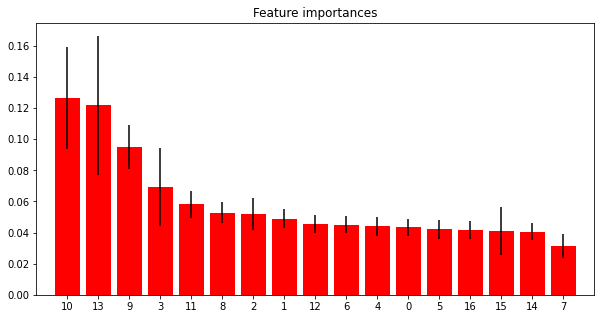

In [14]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[::-1]

# print the feature ranking
df = pd.DataFrame()

print( 'Feature Ranking:\n' )
for i, j in zip( x_train_fselection,forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) ) 

# plot the impurity-based feature importances of the forest
plt.figure(figsize=(10,5))
plt.title( 'Feature importances' )
plt.bar( range( x_train_fselection.shape[1] ), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_fselection.shape[1]), indices )
plt.xlim( [-1, x_train_fselection.shape[1]] )
plt.show()

# 7.0 MACHINE LEARNING

In [15]:
X = features_smt.drop( columns = ['id_cliente','investe_exterior','pessoa_polit_exp','num_consultas_credito'] )
Y = target_smt.copy()
 
X_train, X_val, y_train, y_val = ms.train_test_split( X, Y, test_size=0.2, random_state=42 )

## 7.1 LightGBM

In [16]:
# model
model_lgb = lgb.LGBMClassifier( n_estimators=1356, max_depth=16, learning_rate=0.010563949145404308, num_leaves=101, 
min_child_samples=1, subsample=0.6259906896519882, colsample_bytree= 0.9984729769328018, n_jobs=-1, random_state=42, subsample_freq=1 ).fit( X_train, y_train )
#model_lgb = lgb.LGBMClassifier( n_jobs=-1 ).fit( X_train, y_train )
pickle.dump( model_lgb, open( 'model/model_lgb.pkl', 'wb' ) )
#[1356, 16, 0.010563949145404308, 101, 1, 0.6259906896519882, 0.9984729769328018]

# prediction
yhat_lgb = model_lgb.predict( X_val )

# performance
model_lgb_results = ml_error( 'LightGBM',  y_val, yhat_lgb )
model_lgb_results

,Model name,F1
0,LightGBM,0.935462


### 7.1.1 Cross Validation

In [17]:
# # cross validation
# kfold = KFold(n_splits=5, random_state=1, shuffle=True)
# cv = cross_val_score(model_lgb, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
# print( "{} +/- {}".format( np.mean(cv), np.std(cv)) )

## 7.2 XGBoost

In [18]:
# model
model_xgb = xgb.XGBClassifier( n_estimators=1061, gamma=7, reg_alpha=1, min_child_weight=10,
colsample_bytree=0.8808060214289094, n_jobs=-1 ).fit( X_train, y_train )
# model_xgb = xgb.XGBClassifier( n_jobs=-1 ).fit( X_train, y_train )
#[1061, 7, 1, 10, 0.8808060214289094]

# prediction
yhat_xgb = model_xgb.predict( X_val )

# performance
model_xgb_results = ml_error( 'XGBoost',  y_val, yhat_xgb )
model_xgb_results

,Model name,F1
0,XGBoost,0.931461


### 7.2.1 Cross Validation

In [19]:
# # cross validation
# kfold = KFold(n_splits=5, random_state=1, shuffle=True)
# cv = cross_val_score(model_xgb, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
# print( "{} +/- {}".format( np.mean(cv), np.std(cv)) )

## 7.3 CatBoost

In [20]:
# model
model_cb = CatBoostClassifier( depth=10, learning_rate=0.07965559354949578, iterations=200, verbose=False ).fit( X_train, y_train )
# model_cb = CatBoostClassifier( verbose=False ).fit( X_train, y_train )
#[10, 0.07965559354949578, 200]

# prediction
yhat_cb = model_cb.predict( X_val )

# performance
model_cb_results = ml_error( 'CatBoost',  y_val, yhat_cb)
model_cb_results

,Model name,F1
0,CatBoost,0.936984


### 7.3.1 Cross Validation

## 7.4 Random Forest Classifier

In [21]:
# model
# model_rf = RandomForestClassifier( n_estimators=, max_depth=, min_samples_split=, min_samples_leaf=,
# max_features= ).fit( X_train, y_train )
model_rf = RandomForestClassifier().fit( X_train, y_train )

# prediction
yhat_rf = model_rf.predict( X_val )

# performance
model_rf_results = ml_error( 'CatBoost',  y_val, yhat_rf)
model_rf_results

,Model name,F1
0,CatBoost,0.930049


## 7.5 Extra Trees Classifier

In [22]:
# model
# model_et = ExtraTreesClassifier( n_estimators=268, max_depth=33, min_samples_split=2, min_samples_leaf=1,
#max_features=6 ).fit( X_train, y_train )
model_et = ExtraTreesClassifier().fit( X_train, y_train )
pickle.dump( model_et, open( 'model/model_et.pkl', 'wb' ) )

# prediction
yhat_et = model_et.predict( X_val )

# performance
model_et_results = ml_error( 'CatBoost',  y_val, yhat_et)
model_et_results

,Model name,F1
0,CatBoost,0.93824


## 7.6 KNN

In [23]:
# model
model_knn = KNeighborsClassifier( leaf_size=47, n_neighbors=1, p=1 ).fit( X_train, y_train )
# model_knn = KNeighborsClassifier().fit( X_train, y_train )
#[47, 1, 1]

# prediction
yhat_knn = model_knn.predict( X_val )

# performance
model_knn_results = ml_error( 'KNN',  y_val, yhat_knn)
model_knn_results

,Model name,F1
0,KNN,0.90593


# 7.7 Logistic Regression

In [24]:
# model
model_logistic = LogisticRegression().fit( X_train, y_train )

# prediction
yhat_logistic = model_logistic.predict( X_val )

# performance
model_logistic_results = ml_error( 'Logistic',  y_val, yhat_logistic)
model_logistic_results

,Model name,F1
0,Logistic,0.839297


## 7.8 Naive Bayes

In [25]:
# model
model_gaussian = GaussianNB().fit( X_train, y_train )

# prediction
yhat_gaussian = model_gaussian.predict( X_val )

# performance
model_gaussian_results = ml_error( 'Logistic',  y_val, yhat_gaussian )
model_gaussian_results

,Model name,F1
0,Logistic,0.798884


## 7.9 SVM

In [26]:
# model
model_svm = svm.SVC().fit( X_train, y_train )

# prediction
yhat_svm = model_svm.predict( X_val )

# performance
model_svm_results = ml_error( 'Logistic',  y_val, yhat_svm )
model_svm_results

,Model name,F1
0,Logistic,0.809843


# 7.10 Decision Tree

In [27]:
# model
model_dt = DecisionTreeClassifier( max_depth=10, min_samples_split=2, min_samples_leaf=2, max_features=12 ).fit( X_train, y_train )
# model_dt = DecisionTreeClassifier().fit( X_train, y_train )
#[262, 10, 2, 2, 12]

# prediction
yhat_dt = model_dt.predict( X_val )

# performance
model_dt_results = ml_error( 'Decision Tree',  y_val, yhat_dt )
model_dt_results

,Model name,F1
0,Decision Tree,0.899316


## 7.11 MLP

In [28]:
# Criando a rede neural
rede_neural_credit = MLPClassifier(max_iter=1500, verbose=False, tol=0.000100,
                                   solver = 'adam', activation = 'relu',
                                   hidden_layer_sizes = (30,20)).fit(X_train, y_train)

# Fit vai fazer o ajuste dos pesos (treinamento)
yhat_mlp = rede_neural_credit.predict( X_val )

# Função que faz a contagem dos acertos e dos erros
model_dt_results = ml_error( 'MLP',  y_val, yhat_mlp )
model_dt_results

,Model name,F1
0,MLP,0.87536


## 7.13 Stacking Classifier

In [29]:
estimators_list = [ ('lgbm', model_lgb), ('xgboost', model_xgb), ('catboost', model_cb), ('random forest', model_rf ), ('extra trees', model_et), 
('decision tree', model_dt), ('knn', model_knn), ('logistic regression', model_logistic), ('gaussian', model_gaussian), ('svm', model_svm),('rede neural', rede_neural_credit) ]

# Build stack model
stack_model = StackingClassifier( estimators = estimators_list, n_jobs=-1, verbose=True ).fit( X_train, y_train )
pickle.dump( stack_model, open( 'model/model_stack.pkl', 'wb' ) )

# prediction
yhat_stack = stack_model.predict( X_val )

# performance
stack_model_results = ml_error( 'Stacking', y_val, yhat_stack )
stack_model_results

,Model name,F1
0,Stacking,0.951091


### 7.7.1 Cross Validation

In [30]:
# # cross validation
# kfold = KFold(n_splits=5, random_state=1, shuffle=True)
# cv = cross_val_score(stack_model, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
# print( "{} +/- {}".format( np.mean(cv), np.std(cv)) )

# 8.0 Bayesian Optimization

## 8.1 LGBM

In [31]:
search_space = [(100, 1500), #name = 'n_estimators'), 
                (1, 20), #name = 'max_depth'), 
                (0.001, 0.1, 'log-uniform'),#, name = 'learning_rate'),
                (2, 128), #name = 'num_leaves'),
                (1, 100), #name = 'min_child_samples'),
                (0.05, 1.0), #name = 'subsample'),
                (0.15, 1.0) #name = 'colsample_bytree')]
]

def treinar_modelo( params ):
    n_estimators = params[0]
    max_depth = params[1]
    learning_rate = params[2]
    num_leaves = params[3]
    min_child_samples = params[4]
    subsample = params[5]
    colsample_bytree = params[6]

    print(params, '\n')

    lgbm_model = lgb.LGBMClassifier( learning_rate = learning_rate, num_leaves=num_leaves, n_estimators=n_estimators, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42, subsample_freq=1)
    lgbm_model.fit( X_train, y_train )

    yhat_lgb = lgbm_model.predict( X_val )

    return -m.f1_score( y_val, yhat_lgb )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[1215, 4, 0.036256176345762295, 77, 45, 0.14497617002710278, 0.5403615581709872] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.9450
Function value obtained: -0.9293
Current minimum: -0.9293
Iteration No: 2 started. Evaluating function at random point.
[567, 4, 0.020034427927560734, 9, 72, 0.9416250735649628, 0.15066195096486218] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6590
Function value obtained: -0.9281
Current minimum: -0.9293
Iteration No: 3 started. Evaluating function at random point.
[1489, 13, 0.01672269700618368, 3, 3, 0.5485359272454697, 0.48988182595796725] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.1000
Function value obtained: -0.9290
Current minimum: -0.9293
Iteration No: 4 started. Evaluating function at random point.
[165, 20, 0.0029210748185657135, 13, 62, 0.41333889170380467, 0.9857462529357701] 

Iteration No: 4 ended. E

In [32]:
result.x

[1500, 19, 0.03396546433106691, 128, 1, 0.7182770123184691, 1.0]

## 8.2 XGBoost

In [33]:
search_space = [(100, 1500), #n_estimators
                (1, 9), #gamma, 
                (1, 180),#reg_alpha
                (1, 10), #min_child_weight
                (0.15, 1.0) #colsample_bytree
]

def treinar_modelo( params ):
    n_estimators = params[0]
    gamma = params[1]
    reg_alpha = params[2]
    min_child_weight = params[3]
    colsample_bytree = params[4]

    print(params, '\n')

    xgb_model = xgb.XGBClassifier( n_estimators=n_estimators, gamma=gamma, reg_alpha=reg_alpha, min_child_weight=min_child_weight, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42)
    xgb_model.fit( X_train, y_train )

    yhat_xgb = xgb_model.predict( X_val )

    return -m.f1_score( y_val, yhat_xgb )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[1215, 2, 141, 6, 0.5289578399255526] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.2800
Function value obtained: -0.9008
Current minimum: -0.9008
Iteration No: 2 started. Evaluating function at random point.
[240, 5, 61, 2, 0.703255202006525] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.9240
Function value obtained: -0.9189
Current minimum: -0.9189
Iteration No: 3 started. Evaluating function at random point.
[179, 7, 169, 1, 0.9933798253975351] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.9470
Function value obtained: -0.9006
Current minimum: -0.9189
Iteration No: 4 started. Evaluating function at random point.
[964, 6, 2, 1, 0.5960584612196308] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 13.4285
Function value obtained: -0.9323
Current minimum: -0.9323
Iteration No: 5 started. Evaluating function at random point.
[660

In [34]:
result.x

[100, 4, 1, 1, 0.3166394103324241]

## 8.3 CatBoost

In [35]:
search_space = [(6, 10), #depth
                (0.01, 0.1), #learning rate
                (100, 200), #iterations
]

def treinar_modelo( params ):
    depth = params[0]
    learning_rate = params[1]
    iterations = params[2]

    print(params, '\n' )

    catboost_model = CatBoostClassifier( depth = depth, learning_rate=learning_rate, iterations=iterations, verbose=False )
    catboost_model.fit( X_train, y_train )

    yhat_catboost = catboost_model.predict( X_val )

    return -m.f1_score( y_val, yhat_catboost )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[9, 0.026509131087954746, 178] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.9097
Function value obtained: -0.9267
Current minimum: -0.9267
Iteration No: 2 started. Evaluating function at random point.
[8, 0.05012494775682322, 110] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.0923
Function value obtained: -0.9285
Current minimum: -0.9285
Iteration No: 3 started. Evaluating function at random point.
[8, 0.04003377500251198, 114] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.7071
Function value obtained: -0.9249
Current minimum: -0.9285
Iteration No: 4 started. Evaluating function at random point.
[9, 0.015077042112439026, 172] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.4733
Function value obtained: -0.9171
Current minimum: -0.9285
Iteration No: 5 started. Evaluating function at random point.
[10, 0.01007008892569129, 19

In [ ]:
result.x

[10, 0.07965559354949578, 200]

## 8.4 Random Forest Classifier

In [ ]:
search_space = [(10, 500), # n_estimators
                (1, 50), #max_depth
                (2, 6), #min_sample_split
                (1, 2), #min_sample_leaf
                (1, 50), #max features
]

def treinar_modelo( params ):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]
    max_features = params[4]

    print(params, '\n')

    model_rf = RandomForestClassifier( n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, n_jobs=-1, random_state=42)
    model_rf.fit( X_train, y_train )

    yhat_rf = model_rf.predict( X_val )

    return -m.f1_score( y_val, yhat_rf )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[400, 10, 5, 2, 23] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.1563
Function value obtained: -0.9229
Current minimum: -0.9229
Iteration No: 2 started. Evaluating function at random point.
[59, 24, 3, 1, 33] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.6566
Function value obtained: -0.9289
Current minimum: -0.9289
Iteration No: 3 started. Evaluating function at random point.
[38, 36, 6, 1, 50] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.1110
Function value obtained: -0.9292
Current minimum: -0.9292
Iteration No: 4 started. Evaluating function at random point.
[313, 31, 2, 1, 27] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.2399
Function value obtained: -0.9266
Current minimum: -0.9292
Iteration No: 5 started. Evaluating function at random point.
[206, 3, 6, 1, 5] 

Iteration No: 5 ended. Evaluation done at random po

In [ ]:
result.x

[349, 38, 2, 1, 1]

## 8.5 Extra Trees Classifier

In [ ]:
search_space = [(10, 500), # n_estimators
                (1, 50), #max_depth
                (2, 6), #min_sample_split
                (1, 2), #min_sample_leaf
                (1, 50), #max features
]

def treinar_modelo( params ):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]
    max_features = params[4]

    print(params, '\n')

    model_et = ExtraTreesClassifier( n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, n_jobs=-1, random_state=42)
    model_et.fit( X_train, y_train )

    yhat_et = model_et.predict( X_val )

    return -m.f1_score( y_val, yhat_et )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[400, 10, 5, 2, 23] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3505
Function value obtained: -0.9018
Current minimum: -0.9018
Iteration No: 2 started. Evaluating function at random point.
[59, 24, 3, 1, 33] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3340
Function value obtained: -0.9339
Current minimum: -0.9339
Iteration No: 3 started. Evaluating function at random point.
[38, 36, 6, 1, 50] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2300
Function value obtained: -0.9346
Current minimum: -0.9346
Iteration No: 4 started. Evaluating function at random point.
[313, 31, 2, 1, 27] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.9300
Function value obtained: -0.9402
Current minimum: -0.9402
Iteration No: 5 started. Evaluating function at random point.
[206, 3, 6, 1, 5] 

Iteration No: 5 ended. Evaluation done at random poi

In [ ]:
result.x

[329, 50, 2, 1, 3]

## 8.6 KNN

In [ ]:
search_space = [(1, 50), #leaf_size
                (1, 30), #n_neighbors 
                (1,2) #p
]

def treinar_modelo( params ):
    leaf_size = params[0]
    n_neighbors = params[1]
    p = params[2]

    print(params, '\n')

    knn_model = KNeighborsClassifier( leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, n_jobs=-1 )
    knn_model.fit( X_train, y_train )

    yhat_knn = knn_model.predict( X_val )

    return -m.f1_score( y_val, yhat_knn )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[40, 6, 2] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1760
Function value obtained: -0.8739
Current minimum: -0.8739
Iteration No: 2 started. Evaluating function at random point.
[30, 14, 1] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3200
Function value obtained: -0.8846
Current minimum: -0.8846
Iteration No: 3 started. Evaluating function at random point.
[24, 11, 1] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3350
Function value obtained: -0.8839
Current minimum: -0.8846
Iteration No: 4 started. Evaluating function at random point.
[33, 3, 2] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1595
Function value obtained: -0.8733
Current minimum: -0.8846
Iteration No: 5 started. Evaluating function at random point.
[47, 1, 2] 

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1770
Function value o

In [ ]:
result.x

[47, 1, 1]

## 8.7 Logistic Regression

In [ ]:
# search_space = [(100, 1500), #name = 'n_estimators'), 
#                 (1, 20), #name = 'max_depth'), 
#                 (0.001, 0.1, 'log-uniform'),#, name = 'learning_rate'),
#                 (2, 128), #name = 'num_leaves'),
#                 (1, 100), #name = 'min_child_samples'),
#                 (0.05, 1.0), #name = 'subsample'),
#                 (0.15, 1.0) #name = 'colsample_bytree')]
# ]

# def treinar_modelo( params ):
#     n_estimators = params[0]
#     max_depth = params[1]
#     learning_rate = params[2]
#     num_leaves = params[3]
#     min_child_samples = params[4]
#     subsample = params[5]
#     colsample_bytree = params[6]

#     print(params, '\n')

#     lgbm_model = lgb.LGBMClassifier( learning_rate = learning_rate, num_leaves=num_leaves, n_estimators=n_estimators, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42, subsample_freq=1)
#     lgbm_model.fit( X_train, y_train )

#     yhat_lgb = lgbm_model.predict( X_val )

#     return -m.f1_score( y_val, yhat_lgb )

# result = gp_minimize( treinar_modelo, search_space, n_calls = 200, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

## 8.8 Naive Bayes

In [ ]:
# search_space = [(100, 1500), #name = 'n_estimators'), 
#                 (1, 20), #name = 'max_depth'), 
#                 (0.001, 0.1, 'log-uniform'),#, name = 'learning_rate'),
#                 (2, 128), #name = 'num_leaves'),
#                 (1, 100), #name = 'min_child_samples'),
#                 (0.05, 1.0), #name = 'subsample'),
#                 (0.15, 1.0) #name = 'colsample_bytree')]
# ]

# def treinar_modelo( params ):
#     n_estimators = params[0]
#     max_depth = params[1]
#     learning_rate = params[2]
#     num_leaves = params[3]
#     min_child_samples = params[4]
#     subsample = params[5]
#     colsample_bytree = params[6]

#     print(params, '\n')

#     lgbm_model = lgb.LGBMClassifier( learning_rate = learning_rate, num_leaves=num_leaves, n_estimators=n_estimators, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42, subsample_freq=1)
#     lgbm_model.fit( X_train, y_train )

#     yhat_lgb = lgbm_model.predict( X_val )

#     return -m.f1_score( y_val, yhat_lgb )

# result = gp_minimize( treinar_modelo, search_space, n_calls = 200, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

## 8.9 SVM

In [ ]:
# search_space = [(100, 1500), #name = 'n_estimators'), 
#                 (1, 20), #name = 'max_depth'), 
#                 (0.001, 0.1, 'log-uniform'),#, name = 'learning_rate'),
#                 (2, 128), #name = 'num_leaves'),
#                 (1, 100), #name = 'min_child_samples'),
#                 (0.05, 1.0), #name = 'subsample'),
#                 (0.15, 1.0) #name = 'colsample_bytree')]
# ]

# def treinar_modelo( params ):
#     n_estimators = params[0]
#     max_depth = params[1]
#     learning_rate = params[2]
#     num_leaves = params[3]
#     min_child_samples = params[4]
#     subsample = params[5]
#     colsample_bytree = params[6]

#     print(params, '\n')

#     lgbm_model = lgb.LGBMClassifier( learning_rate = learning_rate, num_leaves=num_leaves, n_estimators=n_estimators, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42, subsample_freq=1)
#     lgbm_model.fit( X_train, y_train )

#     yhat_lgb = lgbm_model.predict( X_val )

#     return -m.f1_score( y_val, yhat_lgb )

# result = gp_minimize( treinar_modelo, search_space, n_calls = 200, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

## 8.10 Decision Tree

In [ ]:
search_space = [(10, 500), # n_estimators
                (1, 50), #max_depth
                (2, 6), #min_sample_split
                (1, 2), #min_sample_leaf
                (1, 50), #max features
]

def treinar_modelo( params ):
    # n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]
    max_features = params[4]

    print(params, '\n')

    model_dt = DecisionTreeClassifier( max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)
    model_dt.fit( X_train, y_train )

    yhat_dt = model_dt.predict( X_val )

    return -m.f1_score( y_val, yhat_dt )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[400, 10, 5, 2, 23] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1110
Function value obtained: -0.9010
Current minimum: -0.9010
Iteration No: 2 started. Evaluating function at random point.
[59, 24, 3, 1, 33] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1440
Function value obtained: -0.8958
Current minimum: -0.9010
Iteration No: 3 started. Evaluating function at random point.
[38, 36, 6, 1, 50] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1440
Function value obtained: -0.8951
Current minimum: -0.9010
Iteration No: 4 started. Evaluating function at random point.
[313, 31, 2, 1, 27] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1410
Function value obtained: -0.8929
Current minimum: -0.9010
Iteration No: 5 started. Evaluating function at random point.
[206, 3, 6, 1, 5] 

Iteration No: 5 ended. Evaluation done at random poi